In [381]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor

In [382]:
import joblib

In [383]:
raw_data = pd.read_csv('additionalData.csv', sep=';')
target_cols = raw_data.columns[0:12]
target = raw_data.loc[:,target_cols]

In [384]:
data = raw_data.drop(target_cols, axis=1)

In [385]:
for c in target_cols:
    target[c]=target[c].apply(lambda x: x.replace(',','.'))
    target[c] = pd.to_numeric(target[c])
    
for c in data.columns:
    data[c]=data[c].apply(lambda x: x.replace(',','.'))
    data[c] = pd.to_numeric(data[c])

In [386]:
train_data, test_data, train_labels, test_labels = train_test_split(data, target, test_size=0.2, random_state=42)

In [387]:
scaler = StandardScaler()
sc_train_data = scaler.fit_transform(train_data)
sc_test_data = scaler.transform(test_data)

In [388]:
sc_train_data.shape

(800, 25)

In [102]:
def draw_grid(model, grid, param, X,y,cv=5, multy=False, draw_std=False):
    param_grid = {param:grid}
    search = GridSearchCV(model, param_grid=param_grid, cv=cv,
                          scoring='neg_mean_squared_error',n_jobs=-1,
                          refit=True).fit(X,y)


    means = abs(search.cv_results_['mean_test_score'])
    error = search.cv_results_['std_test_score']

    plt.figure(figsize=(15,8))
    plt.title('choose '+param)

    plt.plot(grid, means, label='mean squared error', color='red', lw=3)
    if draw_std:
        plt.fill_between(grid, means - 2 * error, means + 2 * error, color='green',
                         label='filled area between errors', alpha=0.5)
    legend_box = plt.legend(framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.xlabel('parameter')
    plt.ylabel('MSE')
    plt.show()
    return search

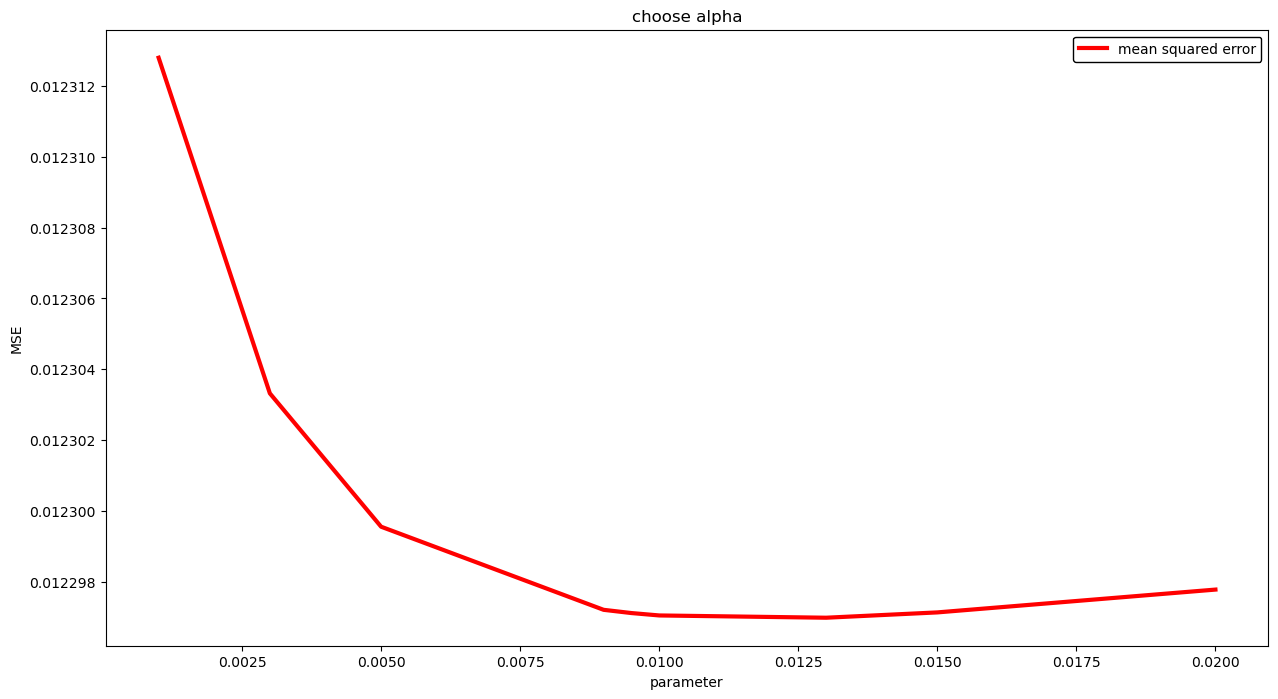

In [170]:
grid=[0.001,0.003,0.005,0.009,0.0095,0.01,0.013,0.015,0.02]
param="alpha"
Ridge_reg_grid = draw_grid(Ridge(), grid, param, sc_train_data, train_labels)

In [171]:
Ridge_reg_grid.best_estimator_

Ridge(alpha=0.013)

In [172]:
mean_squared_error(test_labels, Ridge_reg_grid.best_estimator_.predict(scaler.transform(test_data)))

0.012497793507493799

In [181]:
grid=[0.025,0.027,0.03,0.033,0.035,0.037,0.04]
means = []
for lr in tqdm(grid):
    cat = CatBoostRegressor(loss_function='MultiRMSE', verbose=1000, thread_count=-1, learning_rate=lr ).fit(sc_train_data,train_labels)
    means.append(mean_squared_error(test_labels, cat.predict(scaler.transform(test_data))))
    

  0%|          | 0/7 [00:00<?, ?it/s]

0:	learn: 0.8727935	total: 102ms	remaining: 1m 41s
999:	learn: 0.2691877	total: 23.7s	remaining: 0us
0:	learn: 0.8723857	total: 25.1ms	remaining: 25.1s
999:	learn: 0.2537931	total: 22.7s	remaining: 0us
0:	learn: 0.8717750	total: 22.3ms	remaining: 22.3s
999:	learn: 0.2360679	total: 23.2s	remaining: 0us
0:	learn: 0.8711655	total: 27.6ms	remaining: 27.6s
999:	learn: 0.2205275	total: 23.1s	remaining: 0us
0:	learn: 0.8707599	total: 23.3ms	remaining: 23.2s
999:	learn: 0.2096374	total: 23.1s	remaining: 0us
0:	learn: 0.8703547	total: 22.3ms	remaining: 22.3s
999:	learn: 0.1998066	total: 22.7s	remaining: 0us
0:	learn: 0.8697480	total: 30.5ms	remaining: 30.5s
999:	learn: 0.1870330	total: 23.4s	remaining: 0us


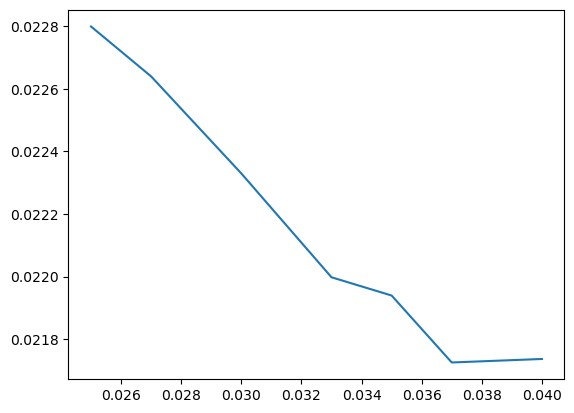

In [182]:
plt.plot(grid, means)
plt.show()

In [183]:
print(np.argmin(means))

5


In [42]:
%%time
grid = {'learning_rate': [0.001,0.01,0.05,0.1,0.2,0.5],
        'depth': [4, 6, 10],
        'n_estimators':[1200],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
cat = CatBoostRegressor(loss_function='MultiRMSE', verbose=100, thread_count=-1)


grid_search_result = cat.grid_search(grid,
                                       X=sc_train_data, 
                                       y=train_labels, 
                                       plot=True)






Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.3922593	test: 2.3860966	best: 2.3860966 (0)	total: 25ms	remaining: 30s
100:	learn: 2.1947709	test: 2.1892401	best: 2.1892401 (100)	total: 896ms	remaining: 9.75s
200:	learn: 2.0181237	test: 2.0132763	best: 2.0132763 (200)	total: 1.73s	remaining: 8.58s
300:	learn: 1.8600339	test: 1.8559185	best: 1.8559185 (300)	total: 2.52s	remaining: 7.54s
400:	learn: 1.7193679	test: 1.7160006	best: 1.7160006 (400)	total: 3.23s	remaining: 6.44s
500:	learn: 1.5941080	test: 1.5914841	best: 1.5914841 (500)	total: 4s	remaining: 5.58s
600:	learn: 1.4828545	test: 1.4809865	best: 1.4809865 (600)	total: 4.8s	remaining: 4.79s
700:	learn: 1.3842034	test: 1.3831034	best: 1.3831034 (700)	total: 5.68s	remaining: 4.04s
800:	learn: 1.2970725	test: 1.2967653	best: 1.2967653 (800)	total: 6.4s	remaining: 3.19s
900:	learn: 1.2200773	test: 1.2205598	best: 1.2205598 (900)	total: 7.18s	remaining: 2.38s
1000:	learn: 1.1522480	test: 1.1535374	best: 1.1535374 (1000)	total: 8.02s	remaining: 1.59s
1100:	learn: 1.09267

600:	learn: 1.4848051	test: 1.4829709	best: 1.4829709 (600)	total: 4.58s	remaining: 4.57s
700:	learn: 1.3862370	test: 1.3851698	best: 1.3851698 (700)	total: 5.29s	remaining: 3.77s
800:	learn: 1.2991390	test: 1.2988628	best: 1.2988628 (800)	total: 5.99s	remaining: 2.98s
900:	learn: 1.2221521	test: 1.2226635	best: 1.2226635 (900)	total: 6.68s	remaining: 2.22s
1000:	learn: 1.1543107	test: 1.1556294	best: 1.1556294 (1000)	total: 7.54s	remaining: 1.5s
1100:	learn: 1.0946888	test: 1.0967927	best: 1.0967927 (1100)	total: 8.28s	remaining: 744ms
1199:	learn: 1.0430612	test: 1.0459031	best: 1.0459031 (1199)	total: 9.07s	remaining: 0us

bestTest = 1.045903078
bestIteration = 1199

6:	loss: 1.0459031	best: 0.4223645 (4)	total: 1m 6s	remaining: 13m 11s
0:	learn: 2.3734677	test: 2.3673581	best: 2.3673581 (0)	total: 12.4ms	remaining: 14.9s
100:	learn: 1.1479799	test: 1.1492931	best: 1.1492931 (100)	total: 833ms	remaining: 9.06s
200:	learn: 0.8007077	test: 0.8083460	best: 0.8083460 (200)	total: 1.6s	r

1199:	learn: 1.0448707	test: 1.0477226	best: 1.0477226 (1199)	total: 9.2s	remaining: 0us

bestTest = 1.047722553
bestIteration = 1199

12:	loss: 1.0477226	best: 0.4206588 (10)	total: 2m 3s	remaining: 12m 12s
0:	learn: 2.3735299	test: 2.3674214	best: 2.3674214 (0)	total: 13.3ms	remaining: 16s
100:	learn: 1.1495965	test: 1.1509332	best: 1.1509332 (100)	total: 735ms	remaining: 8s
200:	learn: 0.8017443	test: 0.8093975	best: 0.8093975 (200)	total: 1.62s	remaining: 8.04s
300:	learn: 0.7046801	test: 0.7150733	best: 0.7150733 (300)	total: 2.32s	remaining: 6.94s
400:	learn: 0.6650605	test: 0.6765900	best: 0.6765900 (400)	total: 3.12s	remaining: 6.23s
500:	learn: 0.6403572	test: 0.6525474	best: 0.6525474 (500)	total: 3.92s	remaining: 5.47s
600:	learn: 0.6217367	test: 0.6344041	best: 0.6344041 (600)	total: 4.82s	remaining: 4.8s
700:	learn: 0.6061476	test: 0.6191566	best: 0.6191566 (700)	total: 5.74s	remaining: 4.09s
800:	learn: 0.5930288	test: 0.6066026	best: 0.6066026 (800)	total: 6.77s	remainin

400:	learn: 0.6658576	test: 0.6773401	best: 0.6773401 (400)	total: 3.01s	remaining: 6s
500:	learn: 0.6411252	test: 0.6532149	best: 0.6532149 (500)	total: 3.71s	remaining: 5.18s
600:	learn: 0.6225899	test: 0.6351197	best: 0.6351197 (600)	total: 4.62s	remaining: 4.61s
700:	learn: 0.6071512	test: 0.6200386	best: 0.6200386 (700)	total: 5.31s	remaining: 3.78s
800:	learn: 0.5943424	test: 0.6078010	best: 0.6078010 (800)	total: 6.04s	remaining: 3.01s
900:	learn: 0.5827965	test: 0.5967695	best: 0.5967695 (900)	total: 6.74s	remaining: 2.24s
1000:	learn: 0.5723317	test: 0.5868129	best: 0.5868129 (1000)	total: 7.44s	remaining: 1.48s
1100:	learn: 0.5627608	test: 0.5778252	best: 0.5778252 (1100)	total: 8.25s	remaining: 742ms
1199:	learn: 0.5539344	test: 0.5696003	best: 0.5696003 (1199)	total: 8.98s	remaining: 0us

bestTest = 0.569600286
bestIteration = 1199

19:	loss: 0.5696003	best: 0.4200839 (16)	total: 3m 9s	remaining: 11m 3s
0:	learn: 2.2907975	test: 2.2849384	best: 2.2849384 (0)	total: 13.5ms	r

1000:	learn: 0.5733759	test: 0.5877488	best: 0.5877488 (1000)	total: 8.49s	remaining: 1.69s
1100:	learn: 0.5640003	test: 0.5789151	best: 0.5789151 (1100)	total: 9.3s	remaining: 836ms
1199:	learn: 0.5552010	test: 0.5707356	best: 0.5707356 (1199)	total: 9.98s	remaining: 0us

bestTest = 0.5707356079
bestIteration = 1199

25:	loss: 0.5707356	best: 0.4200839 (16)	total: 4m 7s	remaining: 10m 8s
0:	learn: 2.2910928	test: 2.2852336	best: 2.2852336 (0)	total: 12.9ms	remaining: 15.5s
100:	learn: 0.6420308	test: 0.6545233	best: 0.6545233 (100)	total: 872ms	remaining: 9.49s
200:	learn: 0.5734176	test: 0.5882344	best: 0.5882344 (200)	total: 1.56s	remaining: 7.75s
300:	learn: 0.5335626	test: 0.5509183	best: 0.5509183 (300)	total: 2.31s	remaining: 6.89s
400:	learn: 0.5064767	test: 0.5270751	best: 0.5270751 (400)	total: 3.13s	remaining: 6.23s
500:	learn: 0.4878121	test: 0.5112112	best: 0.5112112 (500)	total: 3.8s	remaining: 5.3s
600:	learn: 0.4728568	test: 0.4989621	best: 0.4989621 (600)	total: 4.47s	

100:	learn: 0.5869493	test: 0.6102726	best: 0.6102726 (100)	total: 3.14s	remaining: 34.2s
200:	learn: 0.5125638	test: 0.5472429	best: 0.5472429 (200)	total: 6.02s	remaining: 29.9s
300:	learn: 0.4658072	test: 0.5134611	best: 0.5134611 (300)	total: 8.83s	remaining: 26.4s
400:	learn: 0.4343108	test: 0.4929566	best: 0.4929566 (400)	total: 11.7s	remaining: 23.3s
500:	learn: 0.4101787	test: 0.4787939	best: 0.4787939 (500)	total: 14.6s	remaining: 20.4s
600:	learn: 0.3908138	test: 0.4693960	best: 0.4693960 (600)	total: 17.6s	remaining: 17.6s
700:	learn: 0.3742868	test: 0.4620501	best: 0.4620501 (700)	total: 20.8s	remaining: 14.8s
800:	learn: 0.3601342	test: 0.4565316	best: 0.4565316 (800)	total: 24.2s	remaining: 12.1s
900:	learn: 0.3471698	test: 0.4520122	best: 0.4520122 (900)	total: 27.5s	remaining: 9.11s
1000:	learn: 0.3354490	test: 0.4485246	best: 0.4485246 (1000)	total: 31.1s	remaining: 6.18s
1100:	learn: 0.3246790	test: 0.4455457	best: 0.4455457 (1100)	total: 34.9s	remaining: 3.14s
1199:	

700:	learn: 0.3891239	test: 0.4658807	best: 0.4658807 (700)	total: 21.3s	remaining: 15.2s
800:	learn: 0.3757419	test: 0.4598702	best: 0.4598702 (800)	total: 24.3s	remaining: 12.1s
900:	learn: 0.3636537	test: 0.4547042	best: 0.4547042 (900)	total: 27.3s	remaining: 9.05s
1000:	learn: 0.3527180	test: 0.4506246	best: 0.4506246 (1000)	total: 30.3s	remaining: 6.02s
1100:	learn: 0.3425570	test: 0.4470672	best: 0.4470672 (1100)	total: 33.3s	remaining: 3s
1199:	learn: 0.3328053	test: 0.4439764	best: 0.4439763 (1198)	total: 36.3s	remaining: 0us

bestTest = 0.4439762754
bestIteration = 1198

38:	loss: 0.4439763	best: 0.4191143 (28)	total: 10m 57s	remaining: 14m 19s
0:	learn: 2.1862142	test: 2.1813382	best: 2.1813382 (0)	total: 28.2ms	remaining: 33.8s
100:	learn: 0.5188620	test: 0.5502536	best: 0.5502536 (100)	total: 3.01s	remaining: 32.8s
200:	learn: 0.4456634	test: 0.4984096	best: 0.4984096 (200)	total: 5.83s	remaining: 29s
300:	learn: 0.4056187	test: 0.4759436	best: 0.4759436 (300)	total: 8.87s

100:	learn: 0.5232066	test: 0.5531908	best: 0.5531908 (100)	total: 2.81s	remaining: 30.6s
200:	learn: 0.4537164	test: 0.5019653	best: 0.5019653 (200)	total: 5.61s	remaining: 27.9s
300:	learn: 0.4141425	test: 0.4781601	best: 0.4781601 (300)	total: 8.43s	remaining: 25.2s
400:	learn: 0.3873556	test: 0.4651634	best: 0.4651634 (400)	total: 11.2s	remaining: 22.4s
500:	learn: 0.3642928	test: 0.4559355	best: 0.4559355 (500)	total: 14.2s	remaining: 19.8s
600:	learn: 0.3449479	test: 0.4497184	best: 0.4497184 (600)	total: 17s	remaining: 17s
700:	learn: 0.3284966	test: 0.4445086	best: 0.4445086 (700)	total: 20s	remaining: 14.2s
800:	learn: 0.3134878	test: 0.4405366	best: 0.4405214 (799)	total: 22.8s	remaining: 11.4s
900:	learn: 0.2998512	test: 0.4368306	best: 0.4368306 (900)	total: 25.7s	remaining: 8.52s
1000:	learn: 0.2878174	test: 0.4344589	best: 0.4344455 (999)	total: 28.5s	remaining: 5.67s
1100:	learn: 0.2764024	test: 0.4323030	best: 0.4322155 (1094)	total: 31.4s	remaining: 2.82s
1199:	learn: 

700:	learn: 0.3380213	test: 0.4455544	best: 0.4455290 (698)	total: 20.1s	remaining: 14.3s
800:	learn: 0.3235249	test: 0.4414712	best: 0.4414712 (800)	total: 23s	remaining: 11.5s
900:	learn: 0.3102364	test: 0.4382722	best: 0.4382722 (900)	total: 25.9s	remaining: 8.58s
1000:	learn: 0.2983184	test: 0.4355389	best: 0.4355291 (999)	total: 28.7s	remaining: 5.71s
1100:	learn: 0.2872191	test: 0.4333889	best: 0.4333556 (1097)	total: 31.4s	remaining: 2.82s
1199:	learn: 0.2766249	test: 0.4314500	best: 0.4314500 (1199)	total: 34.2s	remaining: 0us

bestTest = 0.4314500459
bestIteration = 1199

51:	loss: 0.4314500	best: 0.4191143 (28)	total: 18m 56s	remaining: 13m 50s
0:	learn: 1.9876489	test: 1.9842358	best: 1.9842358 (0)	total: 27ms	remaining: 32.3s
100:	learn: 0.4636944	test: 0.5096522	best: 0.5096522 (100)	total: 2.86s	remaining: 31.1s
200:	learn: 0.3982777	test: 0.4722831	best: 0.4722831 (200)	total: 5.81s	remaining: 28.9s
300:	learn: 0.3585489	test: 0.4567995	best: 0.4567995 (300)	total: 8.71s

100:	learn: 0.4686966	test: 0.5104301	best: 0.5104301 (100)	total: 3.02s	remaining: 32.9s
200:	learn: 0.4060636	test: 0.4727771	best: 0.4727771 (200)	total: 5.94s	remaining: 29.5s
300:	learn: 0.3661113	test: 0.4550702	best: 0.4550702 (300)	total: 8.85s	remaining: 26.4s
400:	learn: 0.3357610	test: 0.4459724	best: 0.4459644 (397)	total: 11.6s	remaining: 23.2s
500:	learn: 0.3107360	test: 0.4406974	best: 0.4406251 (498)	total: 14.4s	remaining: 20.1s
600:	learn: 0.2887320	test: 0.4360739	best: 0.4360739 (600)	total: 17.3s	remaining: 17.2s
700:	learn: 0.2706650	test: 0.4332719	best: 0.4332365 (699)	total: 20.2s	remaining: 14.4s
800:	learn: 0.2540792	test: 0.4308663	best: 0.4308663 (800)	total: 23.1s	remaining: 11.5s
900:	learn: 0.2394027	test: 0.4295248	best: 0.4293942 (894)	total: 26s	remaining: 8.63s
1000:	learn: 0.2252418	test: 0.4280699	best: 0.4280699 (1000)	total: 28.9s	remaining: 5.74s
1100:	learn: 0.2128197	test: 0.4270304	best: 0.4269384 (1098)	total: 31.6s	remaining: 2.85s
1199:	le

600:	learn: 0.0240834	test: 0.4970584	best: 0.4970584 (600)	total: 4m 33s	remaining: 4m 32s
700:	learn: 0.0159091	test: 0.4969526	best: 0.4969412 (691)	total: 5m 24s	remaining: 3m 50s
800:	learn: 0.0105866	test: 0.4968426	best: 0.4968279 (774)	total: 6m 10s	remaining: 3m 4s
900:	learn: 0.0071357	test: 0.4967878	best: 0.4967878 (900)	total: 6m 54s	remaining: 2m 17s
1000:	learn: 0.0047647	test: 0.4967604	best: 0.4967559 (960)	total: 7m 36s	remaining: 1m 30s
1100:	learn: 0.0032116	test: 0.4967492	best: 0.4967488 (1099)	total: 8m 16s	remaining: 44.7s
1199:	learn: 0.0021890	test: 0.4967477	best: 0.4967445 (1117)	total: 9m	remaining: 0us

bestTest = 0.4967444866
bestIteration = 1117

64:	loss: 0.4967445	best: 0.4191143 (28)	total: 1h 7m 13s	remaining: 25m 51s
0:	learn: 1.3863191	test: 1.4016404	best: 1.4016404 (0)	total: 407ms	remaining: 8m 8s
100:	learn: 0.1404658	test: 0.5532198	best: 0.5532198 (100)	total: 45.3s	remaining: 8m 12s
200:	learn: 0.0455642	test: 0.5526138	best: 0.5525640 (197)

KeyboardInterrupt: 

In [184]:
best_model = CatBoostRegressor(loss_function='MultiRMSE', 
                               verbose=100, thread_count=-1, n_estimators=1500, 
                               learning_rate=grid[np.argmin(means)] ).fit(sc_train_data,train_labels)

0:	learn: 0.8703547	total: 66ms	remaining: 1m 38s
100:	learn: 0.5760196	total: 2.68s	remaining: 37.2s
200:	learn: 0.4803564	total: 4.93s	remaining: 31.9s
300:	learn: 0.4138708	total: 7.21s	remaining: 28.7s
400:	learn: 0.3624968	total: 9.47s	remaining: 25.9s
500:	learn: 0.3230131	total: 11.7s	remaining: 23.3s
600:	learn: 0.2917970	total: 14s	remaining: 20.9s
700:	learn: 0.2634250	total: 16.3s	remaining: 18.6s
800:	learn: 0.2394851	total: 18.5s	remaining: 16.1s
900:	learn: 0.2186066	total: 20.8s	remaining: 13.8s
1000:	learn: 0.1996682	total: 23.1s	remaining: 11.5s
1100:	learn: 0.1829736	total: 25.3s	remaining: 9.17s
1200:	learn: 0.1683398	total: 27.6s	remaining: 6.87s
1300:	learn: 0.1549743	total: 29.8s	remaining: 4.56s
1400:	learn: 0.1428726	total: 32.1s	remaining: 2.27s
1499:	learn: 0.1322716	total: 34.3s	remaining: 0us


In [125]:
best_model.save_model('CatBoost1.pkl')

In [126]:
best_model.predict(scaler.transform(test_data)).shape

(200, 12)

In [127]:
df = best_model.get_feature_importance(prettified=True)
df['Feature']=data.columns[df['Feature Id'].values.astype(int)]
df.drop(['Feature Id'],axis=1).head()

,Importances,Feature
0,10.195835,QPlant_2
1,9.962367,QPlant_3
2,8.909674,QPlant_4
3,7.468568,Q_8
4,6.919132,QPlant_1


In [128]:
mean_squared_error(test_labels, best_model.predict(scaler.transform(test_data)))

0.02104477595955064

In [185]:
test_data.iloc[0:5].to_csv('Test_data.csv', index=False, sep=';')

In [146]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [145]:
joblib.dump(Ridge_reg_grid.best_estimator_, 'ridge_reg.pkl') 

['ridge_reg.pkl']

In [179]:
scaler = joblib.load('scaler.pkl')
model = joblib.load('ridge_reg.pkl')
df = pd.read_csv('Test_data.csv', )
result = pd.DataFrame(model.predict(scaler.transform(df.values)),columns=['valve_'+str(i) for i in range(1,13)])
result

,valve_1,valve_2,valve_3,valve_4,valve_5,valve_6,valve_7,valve_8,valve_9,valve_10,valve_11,valve_12
0,0.484713,0.166178,0.636434,0.631187,0.504617,0.678304,0.570110,0.793999,0.621734,0.469667,0.327185,0.748016
1,0.810122,0.922703,0.375094,0.471989,0.553360,0.932537,0.821243,0.765500,-0.094289,0.117302,1.104494,0.094336
2,0.567490,0.983925,0.863355,0.913604,0.263708,0.401467,0.739184,0.560208,0.725295,0.605725,0.974874,0.463738
3,0.580628,0.813511,0.689971,0.180748,0.277771,0.884489,0.747953,0.631908,0.713379,0.386900,0.554246,0.328643
4,0.803849,0.760927,0.561190,0.395793,0.903907,0.999023,0.701372,0.703281,0.154095,0.118102,0.839248,0.729308


In [ ]:
df = data[['PGRS_1','PGRS_2','QGRS_1','QGRS_2']

In [371]:
test_df = data[['PGRS_1','PGRS_2','QGRS_1','QGRS_2']]
test_sample = test_df.sample(1)
test_sample

,PGRS_1,PGRS_2,QGRS_1,QGRS_2
18,321315.963199,323916.181904,14.226633,14.822864


In [274]:
predict_valves(test_sample,2,0.68,data, models)

            PGRS_1       PGRS_2     QGRS_1     QGRS_2  QPlant_1  QPlant_2  \
233  342727.235006  318083.8458  19.063086  14.956944       3.4       4.4   

     QPlant_3  QPlant_4     P_1     P_2     P_3     P_4     P_5     P_6  \
233      4.97      6.12  243777  220688  219981  233355  236057  235633   

        P_7     P_8     P_9     2  
233  287276  247195  293393  0.68  


ValueError: X has 18 features, but StandardScaler is expecting 25 features as input.

In [322]:
c1 = pd.read_csv('Case1.csv', sep=';')
target_cols = c1.columns[0:12]


c1.head()

,valve_1,valve_2,valve_3,valve_4,valve_5,valve_6,valve_7,valve_8,valve_9,valve_10,...,P_8,P_9,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"245552,273810896","276331,512194954","1,36179521770791","0,656054019185113","0,612302404567854","0,665626624957595","0,706399901061738","2,74433324931124","1,37532425605968","2,05542172783396"
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"232975,204369784","267761,132195546","1,34577657042788","0,636778806042345","0,657119427125529","0,711717507360417","0,702305717210467","2,70514473525486","1,29920317538642","1,74412323861366"
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"245193,113957784","273205,448380368","1,22284275228013","0,621263898918389","0,600071479611730","0,699166912785307","0,702614603499373","2,82803204604918","1,37909764314623","1,36180847919074"
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"239898,123288902","281022,900079230","1,25561066182693","0,663416452992212","0,620991342939909","0,708012676573036","0,702621308871480","2,82842425574394","1,33887361925251","2,54840318412277"
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"241856,111606365","280375,067791009","1,23630404180439","0,646283470753974","0,609649854922713","0,678156183907465","0,684634043785253","2,81469746921704","1,34960387302469","2,58520380363840"


In [323]:
data = c1.drop(target_cols, axis=1)
data = (data.replace(',','.',regex=True)).astype('float')
data.head()

,QGRS_1,QGRS_2,QPlant_1,QPlant_2,QPlant_3,QPlant_4,PGRS_1,PGRS_2,P_1,P_2,...,P_8,P_9,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,15.777672,16.544541,2.988832,4.972050,5.987446,7.230819,307570.037263,311224.936251,239741.497430,210359.283970,...,245552.273811,276331.512195,1.361795,0.656054,0.612302,0.665627,0.706400,2.744333,1.375324,2.055422
1,15.079098,15.250963,3.659871,3.955783,4.540800,7.155344,298087.966126,299684.006014,234925.951465,209666.385601,...,232975.204370,267761.132196,1.345777,0.636779,0.657119,0.711718,0.702306,2.705145,1.299203,1.744123
2,17.242422,14.367834,2.442996,5.084128,5.485566,7.684829,312039.952169,296578.632200,220742.189207,204241.644321,...,245193.113958,273205.448380,1.222843,0.621264,0.600071,0.699167,0.702615,2.828032,1.379098,1.361808
3,14.748056,16.059937,3.211251,5.089297,5.322284,6.184229,306120.741882,311806.033937,225059.432114,206364.039659,...,239898.123289,281022.900079,1.255611,0.663416,0.620991,0.708013,0.702621,2.828424,1.338874,2.548403
4,15.096835,16.088905,3.480205,4.683885,5.588355,6.412203,307987.252721,311598.075136,226196.412776,206778.257972,...,241856.111606,280375.067791,1.236304,0.646283,0.609650,0.678156,0.684634,2.814697,1.349604,2.585204


In [337]:
sc = joblib.load('scaler.pkl')
ans = pd.DataFrame(Ridge_reg_grid.best_estimator_.predict(sc.transform(data.values)), columns=target_cols)
c1[target_cols] = ans
c1 = c1.astype('str')
for c in target_cols:
    c1[c]=c1[c].apply(lambda x: x.replace('.',','))
c1.to_csv('Matvey_inc_case1.csv', index=False, sep=';')

In [292]:
boost_ans = pd.DataFrame(best_model.predict(sc.transform(data.values)), columns=target_cols)
boost_ans

,valve_1,valve_2,valve_3,valve_4,valve_5,valve_6,valve_7,valve_8,valve_9,valve_10,valve_11,valve_12
0,0.758376,0.885155,0.921318,0.615833,0.853582,0.590296,0.689030,0.660135,0.827599,0.887166,0.873827,0.732062
1,0.747163,0.771563,0.728493,0.601292,0.821003,0.630238,0.480972,0.618632,0.745994,0.625382,0.601118,0.788710
2,0.855774,0.731758,0.964724,0.614103,0.679686,0.677067,0.787745,0.743335,0.737543,0.918086,0.855073,0.852035
3,0.724293,0.866056,0.788949,0.697485,0.642164,0.684460,0.688879,0.566094,0.796121,0.893331,0.767438,0.620907
4,0.754488,0.869801,0.803068,0.756926,0.628976,0.621749,0.644370,0.571831,0.880128,0.835882,0.821774,0.653601
5,0.765945,0.850621,0.691195,0.610823,0.891426,0.582770,0.544977,0.693062,0.553563,0.594895,0.901309,0.910025
6,0.836185,0.729007,0.797552,0.611450,0.886252,0.570242,0.669264,0.735245,0.772156,0.775745,0.780462,0.748076
7,0.794941,0.724186,0.938030,0.567849,0.690755,0.708093,0.713855,0.646319,0.698391,0.939489,0.791728,0.705535
8,0.745270,0.707872,0.809328,0.484298,0.895459,0.691488,0.623906,0.708733,0.637490,0.790979,0.951665,0.841192
9,0.721366,0.848481,0.713947,0.750531,0.716450,0.664895,0.605560,0.631439,0.906718,0.747270,0.862461,0.674827


In [301]:
ans.describe().loc['mean']

valve_1     0.733817
valve_2     0.773762
valve_3     0.767741
valve_4     0.718130
valve_5     0.760158
valve_6     0.667083
valve_7     0.739531
valve_8     0.743114
valve_9     0.698542
valve_10    0.703169
valve_11    0.777371
valve_12    0.741912
Name: mean, dtype: float64

In [302]:
boost_ans.describe().loc['mean']

valve_1     0.738343
valve_2     0.774128
valve_3     0.751928
valve_4     0.654119
valve_5     0.744819
valve_6     0.643436
valve_7     0.627048
valve_8     0.645318
valve_9     0.676820
valve_10    0.697650
valve_11    0.774846
valve_12    0.717551
Name: mean, dtype: float64

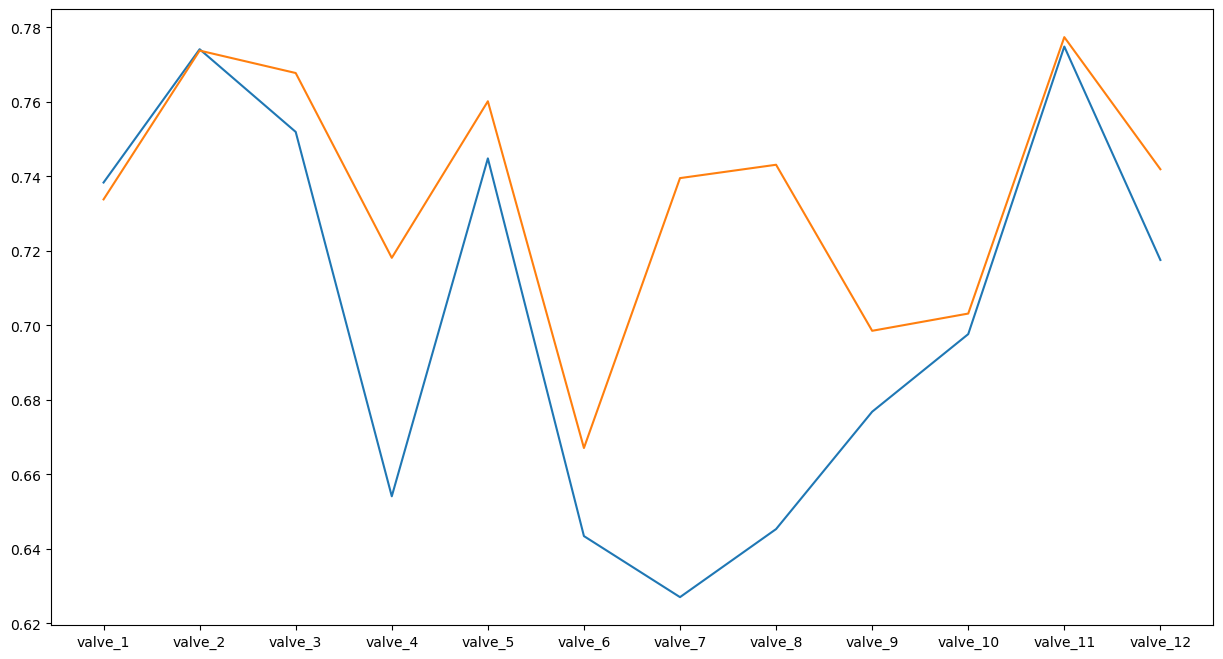

In [306]:
fig, axes = plt.subplots(figsize=(15,8))
plt.plot(boost_ans.describe().loc['mean'])
plt.plot(ans.describe().loc['mean'])
plt.show()

In [294]:
ans.to_csv('Matvey_inc_case1.csv', index=False)

In [296]:
pd.read_csv('Matvey_inc_case1.csv')

,valve_1,valve_2,valve_3,valve_4,valve_5,valve_6,valve_7,valve_8,valve_9,valve_10,valve_11,valve_12
0,0.784042,0.871911,0.918617,0.796795,0.870744,0.493701,0.750936,0.853544,0.817853,0.860802,0.882981,0.813963
1,0.725493,0.783689,0.785711,0.732310,0.865939,0.724342,0.740976,0.796755,0.836955,0.672691,0.645647,0.801263
2,0.850830,0.739389,0.946688,0.687487,0.664179,0.587412,0.775926,0.812364,0.707617,0.884417,0.810267,0.836994
3,0.724890,0.843736,0.779365,0.773459,0.654118,0.621090,0.772477,0.723482,0.804323,0.851825,0.759982,0.635680
4,0.748812,0.845753,0.811010,0.828060,0.650701,0.573020,0.728747,0.722943,0.868529,0.796366,0.800909,0.676029
5,0.758210,0.866250,0.772094,0.686106,0.908838,0.676968,0.745260,0.788975,0.670369,0.644425,0.968771,0.967613
6,0.825649,0.728102,0.792223,0.696782,0.883489,0.610315,0.795103,0.859792,0.802611,0.755694,0.770078,0.738048
7,0.791472,0.739692,0.919186,0.702566,0.683160,0.629970,0.756816,0.792166,0.725402,0.931145,0.761847,0.698970
8,0.708700,0.743375,0.874726,0.656785,0.922079,0.661335,0.774488,0.785293,0.697249,0.746203,0.938691,0.823396
9,0.721905,0.830645,0.692033,0.759423,0.773974,0.577539,0.746601,0.789786,0.866237,0.718561,0.853104,0.712562


In [528]:
c2 = pd.read_csv('Case2.csv', sep=';')
target_cols = c2.columns[0:12]
c2

,valve_1,valve_2,valve_3,valve_4,valve_5,valve_6,valve_7,valve_8,valve_9,valve_10,...,P_8,P_9,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [517]:
target_cols[~(c2.loc[0,target_cols].isna().values)][0][6:]

'4'

In [529]:
def one_valve(df, target):
    models = []
    scalers = []
    for i in tqdm(target_cols):
        X = pd.concat([df, target[i]], axis=1, join="inner")
        s= StandardScaler().fit(X)
        scalers.append(s)
        X = s.transform(X)
        y = target.drop(i, axis=1)
        m = Ridge(alpha=0.013).fit(X,y)
        models.append(m)
    return models, scalers

def predict_valves(df,models, scalers):
    df['Q_1'] = 1.4
    df['Q_2'] = 0.65
    df['Q_3'] = 0.65
    df['Q_4'] = 0.65
    df['Q_5'] = 0.65
    df['Q_6'] = 3
    df['Q_7'] = 1.4
    df['Q_8'] = 2
    df['QPlant_1']=3.4
    df['QPlant_2']=4.4
    df['QPlant_3']=4.97
    df['QPlant_4']=6.12
    df['P_9']=293393
    df['P_8']=247195
    df['P_7']=287276
    df['P_6']=235633
    df['P_5']=236057
    df['P_4']=233355
    df['P_3']=219981
    df['P_2']=220688
    df['P_1']=243777
    for i in range(df.shape[0]):
        t_id = int(target_cols[~(df.loc[i,target_cols].isna().values)][0][6:])-1
        print(t_id)
        df.loc[i,'t']=0
        tdf = df.drop(target_cols, axis=1).loc[i].values.reshape(1, -1)
        preds = models[t_id].predict(scalers[t_id].transform(tdf))
        
        result = preds[0][:t_id]
        
        result = np.append(result,0)
        result = np.append(result,preds[0][t_id:])
        df.loc[i,target_cols]=result
    return df



In [440]:
models, scalers = one_valve(train_data, train_labels)

  0%|          | 0/12 [00:00<?, ?it/s]

In [530]:
c2 = (c2.replace(',','.',regex=True)).astype('float')
c2.head()
ans = predict_valves(c2,models,scalers)
ans

3
3
5
5
6
6
7
7
2
2


,valve_1,valve_2,valve_3,valve_4,valve_5,valve_6,valve_7,valve_8,valve_9,valve_10,...,P_9,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,t
0,0.770232,0.796995,0.772945,0.000000,0.608060,0.917836,1.419153,1.047294,0.494794,0.645977,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
1,0.898820,0.690295,0.734073,0.000000,0.624550,0.449654,0.668453,0.534831,0.540863,0.649260,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
2,0.748978,0.775413,0.780981,0.713939,0.610866,0.000000,1.345366,1.020783,0.443235,0.622692,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
3,0.525142,0.920835,0.893018,0.244727,0.590301,0.000000,2.098726,1.958077,0.821322,0.872913,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
4,0.815386,0.759447,0.742309,0.800508,0.620421,0.828104,0.000000,0.664021,0.409835,0.537388,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
5,0.827399,0.803613,0.720436,0.781093,0.602677,0.558581,0.000000,0.507599,0.357316,0.504256,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
6,0.680645,0.871942,0.791486,0.547869,0.623238,0.664253,1.316673,0.000000,0.555405,0.694888,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
7,0.898763,0.658320,0.712979,0.834285,0.705350,1.137669,1.190666,0.000000,0.536641,0.659667,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
8,0.901442,0.784528,0.000000,0.846582,0.614848,0.541361,0.161180,0.205517,0.287780,0.471520,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
9,0.884824,0.808747,0.000000,0.856014,0.607278,0.561929,0.168975,0.235981,0.258337,0.454257,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0


In [520]:
c2

,valve_1,valve_2,valve_3,valve_4,valve_5,valve_6,valve_7,valve_8,valve_9,valve_10,...,P_9,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,t
0,0.779556,0.785646,0.779323,0.561197,0.000000,0.844713,1.383037,1.050886,0.408522,0.653460,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
1,0.818683,0.000000,0.788856,0.109893,0.390589,-0.508372,-0.176524,0.271387,-0.541860,0.628148,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
2,0.689901,0.000000,0.824952,0.117874,0.352898,0.055066,0.580214,0.737345,-0.785004,0.600722,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
3,0.441231,0.000000,0.955899,-0.444327,0.277772,-0.551723,1.097111,1.630627,-0.634601,0.851429,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
4,0.747799,0.000000,0.789673,0.221299,0.359102,-0.033252,0.170150,0.443198,-0.838578,0.537594,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
5,0.748143,0.000000,0.778282,0.183418,0.324970,-0.444885,-0.397308,0.252269,-0.936972,0.497225,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
6,0.585861,0.000000,0.867582,-0.139481,0.309981,-0.541832,0.313297,0.964360,-0.752841,0.699141,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
7,0.827327,0.000000,0.769188,0.328864,0.471457,0.231704,0.422018,0.417734,-0.467659,0.658059,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
8,0.815360,0.000000,0.744186,0.270117,0.337128,-0.580994,-0.821941,-0.052133,-0.941627,0.450267,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
9,0.796122,0.000000,0.747053,0.261979,0.321147,-0.593473,-0.843323,-0.029991,-1.009272,0.432567,...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0


In [532]:
c2 = c2.astype('str')
for c in target_cols:
    c2[c]=c2[c].apply(lambda x: x.replace('.',','))
c2.to_csv('Matvey_inc_case2.csv', index=False, sep=';')
c2

,valve_1,valve_2,valve_3,valve_4,valve_5,valve_6,valve_7,valve_8,valve_9,valve_10,...,P_9,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,t
0,"0,7702315169284907","0,7969948949428582","0,7729450443605504","0,0","0,6080599440645698","0,9178361597922278","1,4191526567020318","1,047294169333944","0,49479374868441384","0,6459767398191063",...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
1,"0,8988196534587745","0,6902952795075141","0,7340734209105673","0,0","0,6245504588672633","0,449653608441154","0,6684531005698632","0,5348309818339756","0,5408626795297463","0,649260388691063",...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
2,"0,7489780813008574","0,7754130188810531","0,7809807867853529","0,71393942339938","0,6108659815848217","0,0","1,3453658195346456","1,0207830778748375","0,44323537519858436","0,6226923999807481",...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
3,"0,5251423162928567","0,9208345437441134","0,8930177139800726","0,2447273394798365","0,5903010534046202","0,0","2,0987262993023448","1,9580769000094114","0,8213223338706037","0,8729131700044519",...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
4,"0,815385895766198","0,7594468773297084","0,7423089040575689","0,8005075300857215","0,6204208049145902","0,8281043531073686","0,0","0,6640211475958175","0,40983537591148955","0,5373881529725083",...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
5,"0,8273989013501608","0,8036129097595544","0,7204358594265488","0,7810930019851037","0,602677292150379","0,5585809153675589","0,0","0,5075992127467083","0,35731612154558645","0,5042562741992748",...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
6,"0,6806450339460381","0,8719416945440934","0,7914855078832109","0,5478687424230584","0,6232382883999928","0,6642527873860862","1,3166731501830238","0,0","0,5554053980498944","0,6948879657512074",...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
7,"0,8987634791171761","0,6583198422165494","0,7129787401494527","0,8342849556687519","0,7053504041161685","1,1376693490948728","1,1906655044820993","0,0","0,536640607553031","0,6596670951516812",...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
8,"0,9014415302101793","0,7845280070690398","0,0","0,8465819745159386","0,6148478003242822","0,5413608933843561","0,1611797520981556","0,20551688817168007","0,28777957672223053","0,4715198793242268",...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
9,"0,8848241206107048","0,8087472498184853","0,0","0,8560144886833836","0,6072784846483331","0,5619291457980443","0,16897505913069244","0,2359810596652312","0,25833717868075967","0,4542566973086181",...,293393,1.4,0.65,0.65,0.65,0.65,3,1.4,2,0.0
